# Processing Data


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ruff: noqa: E402
# find the root of the project
import os
from pathlib import Path
import sys
import polars as pl
import dotenv


ROOT = Path(os.getcwd()).parent
while not ROOT.joinpath(".git").exists():
    ROOT = ROOT.parent

# add the root to the python path
sys.path.append(str(ROOT))


dotenv.load_dotenv(ROOT.joinpath(".env"))

from src.utils import check_gpu_available

GPU = check_gpu_available()
print(f"GPU available: {GPU}")

GPU available: True


## Load the Network


In [3]:
import geopandas as gpd
from src.geometry import RoadNetwork


mainline_net = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    keep_lanes=["EBL1", "WBL1"],
    step_size=0.01,
)

full_net = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    keep_lanes=None,
    step_size=0.01,
)

LANE_WIDTH = 3.55
LANE_NUM = 2

## Read in the Trajectories


In [4]:
from datetime import timedelta
import polars as pl
from src.radar import CalibratedRadar
from src.pipelines.open_file import prep_df


USE_FRONT = False


radar_obj = CalibratedRadar(
    radar_location_path=ROOT / "configuration" / "march_calibrated.yaml",
)

In [5]:
_df = pl.scan_parquet(
    # Path(os.environ.get("RAW_DATA_DIR")).joinpath("*.parquet")
    Path("/home/max/Development/ua-traffic-data/tmp/all_working.parquet")
    # "/Users/max/Development/DOE-Project/ua-traffic-data/tmp/all_working_processed.parquet"
)

_df.with_columns(
    pl.col("epoch_time").dt.replace_time_zone("UTC").dt.convert_time_zone("US/Central")
).select(
    pl.col("epoch_time").min().alias("min"), pl.col("epoch_time").max().alias("max")
).collect()

shape: (1, 2)
┌─────────────────────────────┬─────────────────────────────┐
│ min                         ┆ max                         │
│ ---                         ┆ ---                         │
│ datetime[ms, US/Central]    ┆ datetime[ms, US/Central]    │
╞═════════════════════════════╪═════════════════════════════╡
│ 2023-03-12 16:41:27.070 CDT ┆ 2023-03-13 19:26:04.171 CDT │
└─────────────────────────────┴─────────────────────────────┘

In [6]:
radar_df = (
    pl.scan_parquet(
        Path("/home/max/Development/ua-traffic-data/tmp/all_working.parquet")
    )
    .with_columns(
        pl.col("epoch_time").dt.replace_time_zone("UTC").dt.round("100ms"),
    )
    .pipe(prep_df, f=radar_obj)
    .collect(streaming=True)
)

function: create_object_id took: 0.00011730194091796875 seconds
function: filter_short_trajectories took: 0.0003750324249267578 seconds
function: clip_trajectory_end took: 0.0002079010009765625 seconds
function: resample took: 0.0002334117889404297 seconds
function: fix_duplicate_positions took: 0.0001442432403564453 seconds
function: set_timezone took: 3.8623809814453125e-05 seconds
function: add_cst_timezone took: 2.7894973754882812e-05 seconds
function: add_heading took: 3.075599670410156e-05 seconds
function: rotate_radars took: 0.0005075931549072266 seconds
function: update_origin took: 0.0004961490631103516 seconds


In [7]:
(
    radar_df.group_by("object_id")
    .agg(
        (
            pl.col("utm_x").diff() ** 2
            + pl.col("utm_y").diff() ** 2
        )
        .sqrt()
        .sum()
        .alias("distance")
    )
    .select(pl.col("distance").mean())
)

shape: (1, 1)
┌────────────┐
│ distance   │
│ ---        │
│ f64        │
╞════════════╡
│ 145.874149 │
└────────────┘

In [8]:
radar_df = (
    pl.scan_parquet(
        Path("/home/max/Development/ua-traffic-data/tmp/all_working.parquet")
    )
    .with_columns(
        pl.col("epoch_time").dt.replace_time_zone("UTC").dt.round("100ms"),
    )
    .pipe(prep_df, f=radar_obj)
    .collect(streaming=True)
    .pipe(
        mainline_net.map_to_lane,
        dist_upper_bound=LANE_WIDTH * LANE_NUM
        - (LANE_WIDTH / 2)
        + 0.5,  # centered on one of the lanes,
        utm_x_col="utm_x",
        utm_y_col="utm_y",
    )
    .rename(
        {
            "name": "lane",
            "angle": "heading_lane",
        }
    )
)

function: create_object_id took: 0.00014781951904296875 seconds
function: filter_short_trajectories took: 0.0004992485046386719 seconds
function: clip_trajectory_end took: 0.0002269744873046875 seconds
function: resample took: 0.00025916099548339844 seconds
function: fix_duplicate_positions took: 0.0001323223114013672 seconds
function: set_timezone took: 4.00543212890625e-05 seconds
function: add_cst_timezone took: 3.266334533691406e-05 seconds
function: add_heading took: 4.00543212890625e-05 seconds
function: rotate_radars took: 0.0004382133483886719 seconds
function: update_origin took: 0.0004069805145263672 seconds


In [9]:
# radar_df.lazy().group_by("object_id").agg(
#     (pl.col("f32_positionX_m").diff() ** 2 + pl.col("f32_positionY_m").diff() ** 2)
#     .sqrt()
#     .sum()
#     .alias("distance")
# ).select(pl.col("distance").mean()).collect()

In [10]:
# radar_df.with_columns(pl.count().over(["epoch_time", "object_id"])).filter(
#     pl.col("count") > 1
# ).sort(["epoch_time", "object_id"]).select(["epoch_time", "object_id", "count"])

In [11]:
from src.pipelines.kalman_filter import (
    prepare_frenet_measurement,
    build_extension,
    add_timedelta,
    build_kalman_id,
    filter_short_trajectories,
)


prediction_length = 4

print(radar_df.shape)

radar_df = (
    radar_df.pipe(add_timedelta, vehicle_id_col=["object_id", "lane"])
    .pipe(build_kalman_id, split_time_delta=prediction_length + 0.1)
    .pipe(filter_short_trajectories, minimum_distance_m=5, minimum_duration_s=2)
    .pipe(prepare_frenet_measurement)
    .pipe(build_extension, seconds=prediction_length)
    .pipe(add_timedelta)
    .collect()
)

print(radar_df.shape)

(38836326, 38)
function: add_timedelta took: 0.00027060508728027344 seconds
function: build_kalman_id took: 0.00034689903259277344 seconds
function: filter_short_trajectories took: 0.0003147125244140625 seconds
function: prepare_frenet_measurement took: 0.0003619194030761719 seconds


function: build_extension took: 45.54254126548767 seconds
function: add_timedelta took: 0.00031948089599609375 seconds
(34098086, 52)


In [12]:
radar_df["epoch_time"].max(), radar_df["epoch_time"].min()

(datetime.datetime(2023, 3, 14, 0, 26, 8, 200000, tzinfo=zoneinfo.ZoneInfo(key='UTC')),
 datetime.datetime(2023, 3, 12, 21, 41, 27, 300000, tzinfo=zoneinfo.ZoneInfo(key='UTC')))

<Axes: xlabel='dist', ylabel='f32_length_m'>

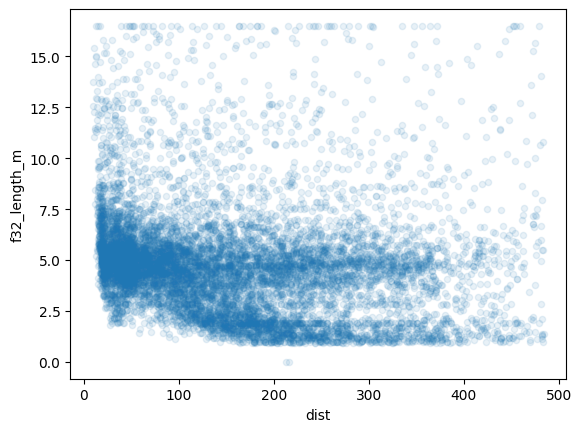

In [13]:
radar_df[["dist", "f32_length_m"]].sample(10_000).to_pandas().plot.scatter(
    x="dist", y="f32_length_m", alpha=0.1
)

<Axes: ylabel='Frequency'>

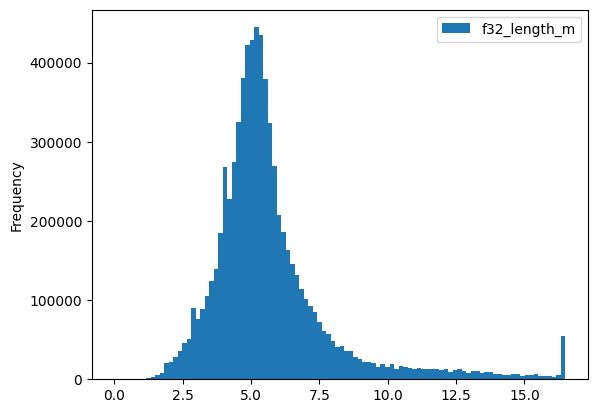

In [14]:
radar_df.filter(pl.col("dist").is_between(10, 50))[
    ["f32_length_m"]
].to_pandas().plot.hist(bins=100)

In [15]:
from src.pipelines.kalman_filter import build_kalman_df

filter_df = (
    radar_df
    # .with_columns((pl.col("distanceToFront_s") + pl.col("s")).alias("front_s"))
    .pipe(build_kalman_df, s_col="front_s" if USE_FRONT else "s", derive_s_vel=False)
    .filter(
        pl.col("max_time") < pl.col("max_time").max()  # filter out the outlier times
    )
    .collect()
)

function: build_kalman_df took: 0.001224517822265625 seconds


### IMM Filter the Radar Trajectories


In [16]:
from src.filters.vectorized_kalman import batch_imm_df
import numpy as np

filt_df = batch_imm_df(
    filter_df.rename({"measurement": "z"}),
    filters=("CALC", "CALK", "CVLK"),
    M=np.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]]),
    mu=np.array([0.1, 0.1, 0.8]),
    # chunk_size=3_500,
    chunk_size=100_000 if not GPU else 9_000 * 1000,
    gpu=GPU,
)

100%|██████████| 6/6 [03:05<00:00, 30.92s/it]


In [17]:
# filt_df.filter(
#     pl.col('s').is_nan().any().over('vehicle_ind')
# ).select(['d', ])

In [18]:
from src.pipelines.kalman_filter import join_results

joined_df = join_results(filt_df, filter_df, radar_df)

if USE_FRONT:
    joined_df = joined_df.rename({"s": "front_s"})

joined_df = joined_df.collect(streaming=True)

function: join_results took: 0.0007987022399902344 seconds


In [19]:
joined_df.lazy().filter(pl.col("s").is_nan().any().over("object_id")).collect()

shape: (96_980, 61)
┌─────┬────────────┬─────────┬─────┬───┬───────────────┬──────────┬───────────────┬──────────┐
│ s   ┆ s_velocity ┆ s_accel ┆ d   ┆ … ┆ utm_x         ┆ utm_y    ┆ x_lane        ┆ y_lane   │
│ --- ┆ ---        ┆ ---     ┆ --- ┆   ┆ ---           ┆ ---      ┆ ---           ┆ ---      │
│ f32 ┆ f32        ┆ f32     ┆ f32 ┆   ┆ f64           ┆ f64      ┆ f64           ┆ f64      │
╞═════╪════════════╪═════════╪═════╪═══╪═══════════════╪══════════╪═══════════════╪══════════╡
│ NaN ┆ NaN        ┆ NaN     ┆ NaN ┆ … ┆ 442388.051618 ┆ 3.6774e6 ┆ 442386.610353 ┆ 3.6774e6 │
│ NaN ┆ NaN        ┆ NaN     ┆ NaN ┆ … ┆ 442387.452768 ┆ 3.6774e6 ┆ 442386.049771 ┆ 3.6774e6 │
│ NaN ┆ NaN        ┆ NaN     ┆ NaN ┆ … ┆ 442386.815374 ┆ 3.6774e6 ┆ 442385.4022   ┆ 3.6774e6 │
│ NaN ┆ NaN        ┆ NaN     ┆ NaN ┆ … ┆ 442385.994305 ┆ 3.6774e6 ┆ 442384.648266 ┆ 3.6774e6 │
│ …   ┆ …          ┆ …       ┆ …   ┆ … ┆ …             ┆ …        ┆ …             ┆ …        │
│ NaN ┆ NaN        ┆ NaN     ┆ NaN ┆ … ┆ 442742.813031 ┆ 3.6775e6 ┆ 442742.773952 ┆ 3.6775e6 │
│ NaN ┆ NaN        ┆ NaN     ┆ NaN ┆ … ┆ 442742.813031 ┆ 3.6775e6 ┆ 442742.773952 ┆ 3.6775e6 │
│ NaN ┆ NaN        ┆ NaN     ┆ NaN ┆ … ┆ 442742.813031 ┆ 3.6775e6 ┆ 442742.773952 ┆ 3.6775e6 │
│ NaN ┆ NaN        ┆ NaN     ┆ NaN ┆ … ┆ 442742.813031 ┆ 3.6775e6 ┆ 442742.773952 ┆ 3.6775e6 │
└─────┴────────────┴─────────┴─────┴───┴───────────────┴──────────┴───────────────┴──────────┘

In [20]:
# if "joined_df" not in locals():
#     joined_df = pl.read_parquet(
#         Path(os.environ.get("RAW_DATA_DIR"))
#         / "march_kalman_filter_results"
#         / "*/*.parquet",
#         use_pyarrow=True,
#         memory_map=True,
#     )

In [21]:
joined_df = joined_df.lazy().sort("epoch_time").collect(streaming=True).rechunk()

## Plotting the Lanes


/tmp/ipykernel_829808/3279628705.py:29: DeprecationWarning: `rstrip` is deprecated. It has been renamed to `strip_chars_end`.
  pl.col('lane').str.rstrip('L1')


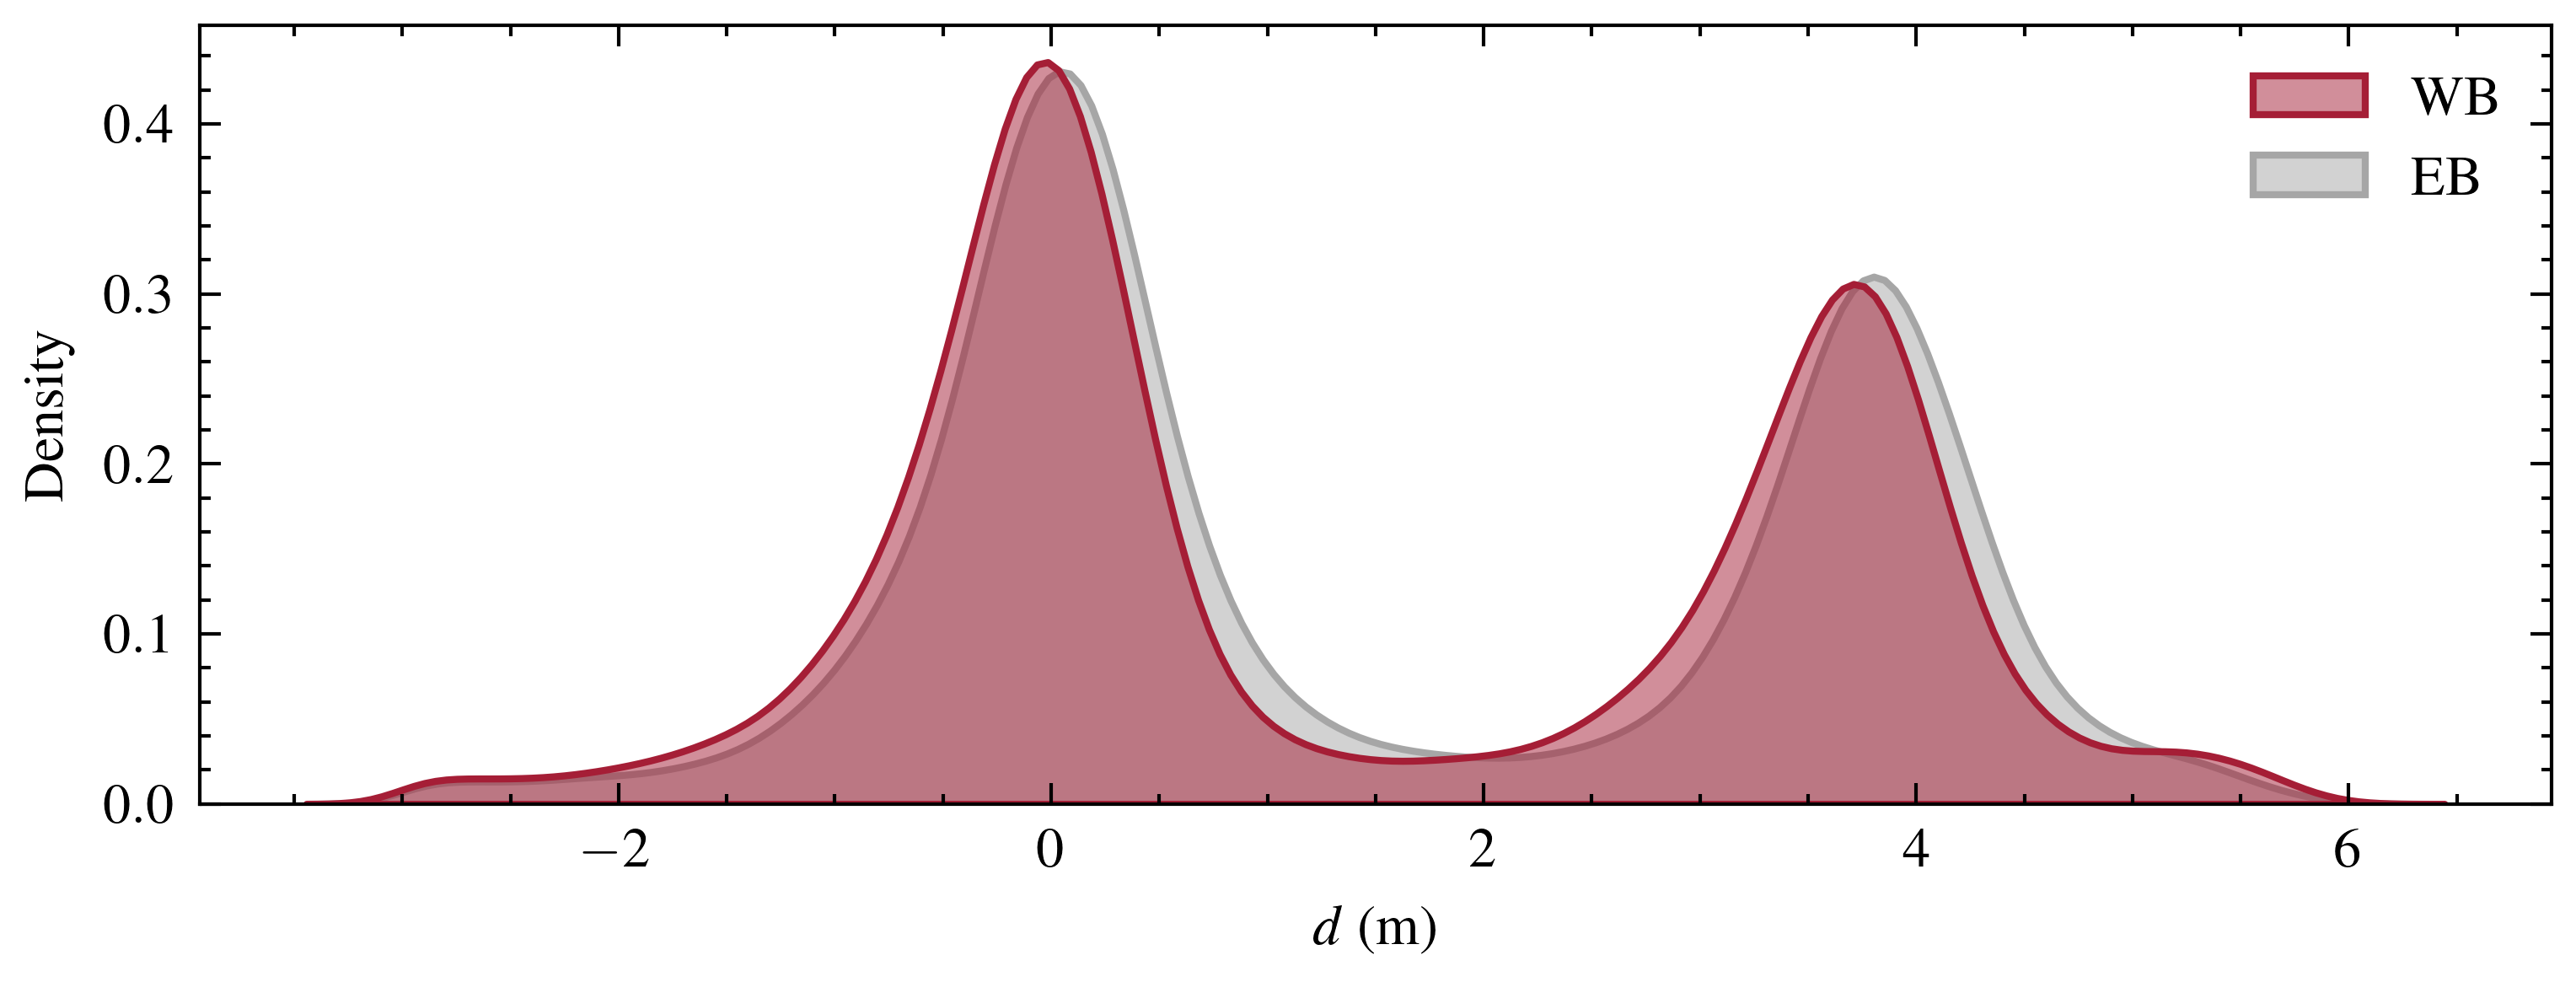

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

engine_color = [0.65, 0.65, 0.65]
gps_color = [0, 0, 0.75]
plutron_color = [0, 0, 0]
alabama = [165, 30, 54]
alabama = [i / 255 for i in alabama]

plt.style.use(["science", "ieee"])

fig, ax = plt.subplots(
    figsize=(6, 2),
)

# create a kde plot of the d dimension in both directions
lane_df = (
    joined_df.select(
        [
            "lane",
            "d",
        ]
    )
    .melt(id_vars="lane", value_name="d")
    .filter(pl.col("d").is_between(-3, 6))
    .sample(1_000_000)
    .with_columns(
        pl.col('lane').str.rstrip('L1')
    )
)


lane_df = lane_df.to_pandas()

sns.kdeplot(
    data=lane_df,
    x="d",
    hue="lane",
    fill=True,
    common_norm=False,
    alpha=0.5,
    ax=ax,
    linewidth=1,
    palette=[alabama, engine_color],
)

# ax.set_xlim(-2, 6)

ax.set_xlabel("$d$ (m)")
# remove the title of the legend
ax.get_legend().set_title("")

# st th

In [23]:
lane_df.head()

lane variable         d
0   WB        d  3.910443
1   WB        d  0.089393
2   WB        d  3.719212
3   WB        d  0.002055
4   EB        d  1.345327

### Classify the Lanes


In [24]:
from src.pipelines.lane_classification import label_lane, label_lanes_tree
from src.gmm.lane_classification import build_lane_model
from src.plotting.lane_gmm import plot_model

In [25]:
joined_df = joined_df.pipe(
    label_lanes_tree,
    full_network=full_net,
    kalman_network=mainline_net,
    lane_width=LANE_WIDTH,
    s_col="front_s" if USE_FRONT else "s",
)


print(joined_df.filter(pl.col("lane_index").is_null()).shape[0] / joined_df.shape[0])

joined_df = joined_df.with_columns(pl.col("lane_index").fill_null(2))

0.06286999506937194


In [26]:
# fig, ax = plt.subplots(
#     figsize=(4, 2.5),
# )

# lane_df = (
#     joined_df.select(
#         [
#             pl.concat_str([pl.col("lane"), pl.col("lane_index").cast(str)]).alias(
#                 "lane"
#             ),
#             "d",
#         ]
#     )
#     .melt(id_vars="lane", value_name="d")
#     .filter(pl.col("d").is_between(-6, 6))
#     .sample(1_000_000)
# )


# lane_df = lane_df.to_pandas()

# sns.kdeplot(
#     data=lane_df,
#     x="d",
#     hue="lane",
#     fill=True,
#     common_norm=True,
#     alpha=0.5,
#     ax=ax,
#     linewidth=1,
#     palette=[alabama, engine_color, gps_color, plutron_color],
# )

# ax.set_xlim(-2, 6)

# ax.set_xlabel("$d$ (m)")
# # remove the title of the legend
# ax.get_legend().set_title("")

# # st th

## Save the Kalman Filtered Trajectories


## Merge the Trajectories


#### Things to try:

1. Ignore sublanes
2. Can you do x/y instead of s/d?
3.


In [27]:
from src.pipelines.association import (
    build_leader_follower_df,
    add_front_back_s,
    build_leader_follower_entire_history_df,
)

joined_df = (
    joined_df.lazy()
    .pipe(
        add_front_back_s,
        use_global_median=True,
    )
    .sort(by=["epoch_time"])
    .set_sorted(["epoch_time"])
    .collect(streaming=True)
)

function: add_front_back_s took: 0.09842634201049805 seconds


In [28]:
# joined_df['lane_index']

In [29]:
lf_df = (
    joined_df.lazy()
    .pipe(
        build_leader_follower_entire_history_df,
        s_col="front_s" if USE_FRONT else "s",
        use_lane_index=True,
        max_s_gap=0.5 * 25,  # max headway of 0.5 seconds at 25 m/s
    )
    # .filter(~(pl.col("prediction") & pl.col("prediction_leader")))
    .filter(pl.col("lane_index") <= 1)
    .collect(streaming=True)
)

function: lazy_func took: 0.0010993480682373047 seconds


### Calculate the Association Log-Likelihood Distance


In [30]:
from src.pipelines.association import calc_assoc_liklihood_distance

dims = 4

lf_df = lf_df.pipe(calc_assoc_liklihood_distance, gpu=GPU, dims=dims, permute=False)

function: lazy_func took: 63.676220417022705 seconds


### Calculate the Match Indexes


In [31]:
from scipy.stats import chi2
from src.pipelines.association import (
    calculate_match_indexes,
    pipe_gate_headway_calc,
    build_match_df,
    # filter_bad_lane_matches,
)

# prediction_length = 4

assoc1_df = (
    lf_df
    # is this really necessary? Just filters the match for a certain tome
    .pipe(calculate_match_indexes, min_time_threshold=1)
    .pipe(
        pipe_gate_headway_calc,
        window=20,
        association_dist_cutoff=chi2.ppf(0.95, dims),
    )
    .collect(streaming=True)
)

function: lazy_func took: 0.0008997917175292969 seconds
function: lazy_func took: 0.00029397010803222656 seconds


In [32]:
match_df = (
    assoc1_df.lazy()
    .pipe(
        build_match_df,
        traj_time_df=joined_df.group_by("object_id")
        .agg(
            pl.col("epoch_time").max().alias("epoch_time_max"),
        )
        .lazy(),
        assoc_cutoff=chi2.ppf(0.95, dims),
        assoc_cutoff_pred=chi2.ppf(0.95, dims),
        time_headway_cutoff=0.01,
    )
    .collect(streaming=True)
)


# 1 - 0.99

function: lazy_func took: 0.24796366691589355 seconds


In [33]:
# assoc1_df

### Re-Label the Joined Trajectories


In [34]:
from src.pipelines.association import create_vehicle_ids
import networkx as nx
from itertools import combinations
from networkx.algorithms.connectivity import (
    node_connectivity,
    all_pairs_node_connectivity,
)

cc, G, assoc_df = joined_df.pipe(
    create_vehicle_ids,
    match_df,
)


def get_ordered_combinations(cc_list):
    return [
        (int(start), int(end), veh_i) if start < end else (end, start, veh_i)
        for veh_i, cc_list in enumerate(cc)
        for start, end in combinations(cc_list, 2)
    ]

function: lazy_func took: 1.4967520236968994 seconds
function: lazy_func took: 2.0506784915924072 seconds


In [35]:
need2_filt_ids = (
    assoc_df.with_columns(pl.count().over(["epoch_time", "vehicle_id"]).alias("count"))
    .filter(pl.col("count").max().over("vehicle_id") > 2)["vehicle_id"]
    .unique()
)

In [36]:
len(need2_filt_ids)

18408

In [37]:
begin_end_df = joined_df.group_by("object_id").agg(
    pl.col("epoch_time").min().alias("begin_time"),
    pl.col("epoch_time").max().alias("end_time"),
)

combs = get_ordered_combinations(cc)

permute_df = (
    pl.DataFrame(
        combs,
        schema={"start": pl.UInt64, "end": pl.UInt64, "vehicle_index": pl.Int64},
    )
    .filter(pl.col("vehicle_index").is_in(need2_filt_ids))
    .join(begin_end_df.rename({"object_id": "start"}), on="start", how="left")
    .join(
        begin_end_df.rename({"object_id": "end"}),
        on="end",
    )
    # filter for overlap in time
    .filter(
        pl.min_horizontal(pl.col("end_time"), pl.col("end_time_right"))
        > pl.max_horizontal(pl.col("begin_time"), pl.col("begin_time_right"))
    )
    .with_columns(
        # sort the object id and leader
        pl.when(pl.col("start") < pl.col("end"))
        .then(pl.concat_list([pl.col("start"), pl.col("end")]))
        .otherwise(pl.concat_list([pl.col("end"), pl.col("start")]))
        .alias("pair")
    )
    .with_columns(pl.col("pair").hash().alias("pair_hash"))
    .with_columns(
        pl.concat_str(
            [pl.col("pair").list.get(0), pl.col("pair").list.get(1)], separator="-"
        ).alias("pair_str")
    )
    .with_columns(
        pl.lit(None, dtype=pl.Float64).alias("association_distance_filt"),
    )
    .join(
        match_df.with_columns(
            pl.concat_str(
                [pl.col("pair").list.get(0), pl.col("pair").list.get(1)], separator="-"
            ).alias("pair_str"),
            (pl.col('prediction') | pl.col('prediction_leader')).alias('prediction')
        ).select(['pair_str', 'prediction']),
        on='pair_str',
        how='left'
    )
    .with_columns(pl.col('prediction').fill_null(False))
)

In [38]:
need2compute = permute_df.filter(pl.col("association_distance_filt").is_null()).select(
    "start", "end", "pair_hash", "vehicle_index", 'prediction'
)

cols = [
    pl.col("object_id"),
    "epoch_time",
    "s",
    "lane",
    "d",
    "s_velocity",
    "d_velocity",
    "front_s",
    "back_s",
    "P",
    "prediction",
]

need2compute = (
    need2compute.lazy()
    .join(
        joined_df.lazy()
        # .filter(~(pl.col("prediction")))
        .select(cols).rename({"object_id": "start"}),
        on="start",
    )
    .join(
        joined_df.lazy()
        # .filter(~(pl.col("prediction")))
        # .filter((pl.col("lane_index") < 2))
        .select(cols).rename({"object_id": "end"}),
        on=["end", "epoch_time"],
        suffix="_leader",
    )
    .filter((pl.sum_horizontal('prediction', 'prediction_right', 'prediction_leader') == 0) |  (pl.col('prediction') & (
        pl.col('prediction_right') | pl.col('prediction_leader')
    )))
    .collect()
    .pipe(calc_assoc_liklihood_distance, gpu=GPU, dims=dims, permute=False)
    .lazy()
    .with_columns(
        pl.col("association_distance")
        .rolling_mean(window_size=20, min_periods=1)
        .over("pair_hash")
    )
    .group_by("pair_hash")
    .agg(
        pl.col("association_distance").mean().alias("association_distance_filt"),
        pl.col("epoch_time")
        .filter(pl.col("association_distance") < chi2.ppf(0.95, dims))
        .first()
        .alias("join_time"),
    )
    .collect()
)


permute_df = permute_df.update(need2compute, on="pair_hash", how="left").filter(pl.col("association_distance_filt").is_not_null())

function: lazy_func took: 35.905712366104126 seconds


In [39]:
big_G = nx.Graph()

for d in permute_df.select(["start", "end", "association_distance_filt"]).to_dicts():
    big_G.add_edge(d["start"], d["end"], weight=d["association_distance_filt"])

cropped_G = nx.subgraph_view(G, filter_node=lambda x: x in big_G.nodes)

bad_edges = nx.difference(big_G, cropped_G).copy()
# update the weights from bigG
for u, v in bad_edges.edges:
    bad_edges[u][v]["weight"] = big_G[u][v]["weight"]

In [40]:
permute_df.group_by(pl.col("vehicle_index")).agg(
    pl.col("association_distance_filt").max() > chi2.ppf(0.999, dims)
).select(pl.count(), pl.col("association_distance_filt").sum())

shape: (1, 2)
┌───────┬───────────────────────────┐
│ count ┆ association_distance_filt │
│ ---   ┆ ---                       │
│ u32   ┆ u32                       │
╞═══════╪═══════════════════════════╡
│ 18408 ┆ 4961                      │
└───────┴───────────────────────────┘

In [41]:
from src.pipelines.association import walk_graph_removals
from copy import deepcopy
from tqdm import tqdm

In [42]:
remove_edges = []

for veh in tqdm(
    permute_df[
        # .filter(
        #     pl.col("association_distance_filt").mean().over("vehicle_index")
        #     > chi2.ppf(0.9999, dims)
        # )
        "vehicle_index"
    ].unique()
):
    # if veh != 1943:
    #     continue

    remove_edges.extend(
        walk_graph_removals(
            cropped_G.subgraph(cc[veh]).copy(),
            max_removals=20,
            cutoff=chi2.ppf(0.999, dims),
            # score_func=lambda y: 0.1
            # df=permute_df.filter(pl.col("vehicle_index") == veh),
            big_G=big_G,
        )
    )

100%|██████████| 18408/18408 [01:07<00:00, 273.61it/s]


In [43]:
from src.pipelines.association import make_graph_based_ids

mainG = G.copy()

# remove_edges = correction_df["remove_edges"].to_list()

for edge in remove_edges:
    mainG.remove_edge(*edge)

assoc_df = make_graph_based_ids(assoc_df.drop("vehicle_id"), mainG)

function: lazy_func took: 1.494288444519043 seconds


In [44]:
import plotly.graph_objects as go
from src.plotting.time_space import plot_time_space
from datetime import timedelta


fig = go.Figure()

# 2023-03-12 21:42:21.100

# get a 10 minute window
plot_df = (
    assoc_df
    # .with_columns(pl.col("").alias("s"))
    .pipe(radar_obj.add_cst_timezone)
    # .sort("epoch_time_cst")
    .filter(
        pl.col("epoch_time_cst").is_between(
            pl.lit("2023-03-12 17:42:54").str.strptime(
                pl.Datetime(time_unit="ns", time_zone="US/Central"),
            ),
            pl.lit("2023-03-12 17:49:00").str.strptime(
                pl.Datetime(time_unit="ns", time_zone="US/Central"),
            ),
        )
        & (pl.col("lane").str.contains("W"))
        & (pl.col("lane_index") == 0)
    )
    # .with_columns(
    #     (pl.col("front_s").max() - pl.col("front_s")).alias("front_s"),
    # )
    # .filter(pl.col("vehicle_id") == 886)
)

fig = plot_time_space(
    plot_df,
    hoverdata="object_id",
    vehicle_col="vehicle_id",
    s_col="s",
    markers=True,
    fig=fig,
    every=2,
)

fig.update_layout(yaxis_autorange="reversed")


fig.show()

function: add_cst_timezone took: 0.0003173351287841797 seconds


## Fuse & Smooth the Trajectories


In [45]:
# assoc_df.filter(
#     pl.col('vehicle_id').is_in([518, ])
# ).with_columns(
#     pl.count().over('epoch_time').alias('count')
# ).filter(
#     (pl.col('count') > 1)
# ).sort(
#     ['epoch_time', 'ip']
# ).with_c

In [46]:
from src.pipelines.association import build_fusion_df

fusion_df = (
    assoc_df
    .pipe(build_fusion_df, prediction_length=prediction_length, max_vehicle_num=3)
    .collect(streaming=True)
    .pipe(
        radar_obj.add_cst_timezone,
        time_col="epoch_time",
    )
)
# fusion_df.head()

function: lazy_func took: 79.96775436401367 seconds
function: add_cst_timezone took: 0.0005421638488769531 seconds


In [47]:
distance_adjuster = (
    fusion_df.group_by(
        [
            "vehicle_id",
            "time_index",
        ]
    )
    .agg(
        pl.col("distanceToFront_s")
        .filter(pl.col("approaching"))
        .mean()
        .alias("distanceToFront_s"),
        pl.col("distanceToBack_s")
        .filter(~pl.col("approaching"))
        .mean()
        .alias("distanceToBack_s"),
        pl.col("distanceToFront_s").mean().alias("distanceToFront_s_all"),
        pl.col("distanceToBack_s").mean().alias("distanceToBack_s_all"),
    )
    .with_columns(
        pl.when(pl.col("distanceToFront_s").is_null())
        .then(pl.col("distanceToFront_s_all"))
        .otherwise(pl.col("distanceToFront_s"))
        .alias("distanceToFront_s"),
        pl.when(pl.col("distanceToBack_s").is_null())
        .then(pl.col("distanceToBack_s_all"))
        .otherwise(pl.col("distanceToBack_s"))
        .alias("distanceToBack_s"),
    )
    .drop(["distanceToFront_s_all", "distanceToBack_s_all"])
)

In [49]:
outer_df = (
    fusion_df.select(
        [
            "front_s",
            "s",
            "back_s",
            "s_velocity",
            "d",
            "d_velocity",
            "P",
            "vehicle_id",
            "time_index",
            "vehicle_time_index_int",
            "prediction",
            "length_s",
        ]
    )
    .lazy()
    .filter(~pl.col("prediction"))
)

outer_df = (
    (
        outer_df.join(
            outer_df,
            on=["time_index", "vehicle_id"],
            how="outer",
            suffix="_leader",
        )
    )
    .with_columns(
        pl.struct(
            [
                pl.min_horizontal(
                    [
                        pl.col("vehicle_time_index_int"),
                        pl.col("vehicle_time_index_int_leader"),
                    ]
                ).alias("one"),
                pl.max_horizontal(
                    [
                        pl.col("vehicle_time_index_int"),
                        pl.col("vehicle_time_index_int_leader"),
                    ]
                ).alias("two"),
            ]
        ).alias("vehicle_time_struct"),
    )
    # .collect()
    .filter(
        (
            pl.col("vehicle_time_index_int")
            .cum_count()
            .over(["vehicle_id", "time_index", "vehicle_time_struct"])
            < 1
        )
        & (pl.col("vehicle_time_index_int") != pl.col("vehicle_time_index_int_leader"))
    )
    .collect(streaming=True)
    .pipe(
        calc_assoc_liklihood_distance,
        gpu=GPU,
        dims=4,
    )
    .group_by(["vehicle_id", "time_index"])
    .agg(pl.col("association_distance").max())
)

function: lazy_func took: 35.15890836715698 seconds


In [50]:
prediction_tracker = (
    fusion_df.select(
        [
            "vehicle_id",
            "time_index",
            # "vehicle_time_index_int",
            "prediction",
        ]
    )
    .lazy()
    .group_by(["vehicle_id", "time_index"])
    .agg(pl.col("prediction").all().alias("prediction"))
    .collect()
)

In [51]:
def list_converter(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns(
        pl.col(df.columns[i]).arr.to_list()
        for i, dtype in enumerate(df.dtypes)
        if "Array" in str(dtype)
    )


def array_converter(df: pl.DataFrame):
    df = df.lazy()
    list_cols = []
    for col, dtype in zip(df.columns, df.dtypes):
        if "List" in str(dtype):
            list_cols.append(col)

    lens = df.select(pl.col(list_cols).list.len().first()).fetch(1)

    return df.with_columns(
        pl.col(col).list.to_array(width=lens[col][0]) for col in list_cols
    ).collect()

In [ ]:
# fusion_df.lazy().pipe(list_converter).collect().pipe(array_converter)

In [52]:
fusion_df.lazy().pipe(list_converter).sink_parquet(
    ROOT / "data" / "fusion_df.tmp.parquet"
)
outer_df.lazy().pipe(list_converter).sink_parquet(
    ROOT / "data" / "outer_df.tmp.parquet"
)
distance_adjuster.lazy().pipe(list_converter).sink_parquet(
    ROOT / "data" / "distance_adjuster.tmp.parquet"
)
prediction_tracker.lazy().pipe(list_converter).sink_parquet(
    ROOT / "data" / "prediction_tracker.tmp.parquet"
)

In [53]:
fusion_df = pl.scan_parquet(ROOT / "data" / "fusion_df.tmp.parquet").pipe(
    array_converter
)
outer_df = pl.scan_parquet(ROOT / "data" / "outer_df.tmp.parquet").pipe(array_converter)
distance_adjuster = pl.scan_parquet(
    ROOT / "data" / "distance_adjuster.tmp.parquet"
).pipe(array_converter)
prediction_tracker = pl.scan_parquet(
    ROOT / "data" / "prediction_tracker.tmp.parquet"
).pipe(array_converter)

In [54]:
from src.filters.fusion import batch_join, rts_smooth

GPU = True

In [55]:
merged_df = batch_join(
    fusion_df,
    method="ImprovedFastCI",
    batch_size=10_000 if not GPU else 3_000,
    gpu=GPU,
    s_col="s",
)

100%|██████████| 1573/1573 [00:15<00:00, 99.09it/s] 


In [56]:
merged_df.lazy().pipe(list_converter).sink_parquet(
    ROOT / "data" / "merged_df.tmp.parquet"
)

In [57]:
merged_df = pl.scan_parquet(ROOT / "data" / "merged_df.tmp.parquet").pipe(
    array_converter
)

In [58]:
merged_df = rts_smooth(
    merged_df, batch_size=10_000 if not GPU else 10_000, gpu=GPU, s_col="s"
)

/home/max/Development/roadside-radar/src/filters/fusion.py:1173: UserWarning:

The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)

  0%|          | 0/693 [00:00<?, ?it/s]/home/max/Development/roadside-radar/src/filters/vectorized_kalman.py:508: UserWarning:

torch.linalg.svd: During SVD computation with the selected cusolver driver, batches 0 failed to converge. A more accurate method will be used to compute the SVD as a fallback. Check doc at https://pytorch.org/docs/stable/generated/torch.linalg.svd.html (Triggered internally at ../aten/src/ATen/native/cuda/linalg/BatchLinearAlgebraLib.cpp:869.)

100%|██████████| 1573/1573 [00:07<00:00, 20

In [62]:
merged_df.head()

shape: (5, 35)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ time_inde ┆ ci_s      ┆ ci_s_velo ┆ ci_s_acce ┆ … ┆ ci_front_ ┆ ci_back_s ┆ front_s_s ┆ back_s_s │
│ x         ┆ ---       ┆ city      ┆ l         ┆   ┆ s         ┆ ---       ┆ mooth     ┆ mooth    │
│ ---       ┆ f64       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ ---      │
│ u32       ┆           ┆ f32       ┆ f32       ┆   ┆ f64       ┆           ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0         ┆ 342.9464  ┆ 23.258364 ┆ 0.0       ┆ … ┆ 343.50919 ┆ 342.38360 ┆ 343.85331 ┆ 342.7277 │
│           ┆           ┆           ┆           ┆   ┆ 3         ┆ 6         ┆           ┆ 22       │
│ 0         ┆ 425.57713 ┆ 1.417838  ┆ 0.0       ┆ … ┆ 427.35673 ┆ 423.79752 ┆ 429.13225 ┆ 425.5730 │
│           ┆           ┆           ┆           ┆   ┆ 9         ┆ 1         ┆ 1         ┆ 33       │
│ 0         ┆ 437.97399 ┆ 2.644333  ┆ 0.0       ┆ … ┆ 440.04910 ┆ 435.89888 ┆ 442.76281 ┆ 438.6126 │
│           ┆ 5         ┆           ┆           ┆   ┆ 1         ┆ 9         ┆ 6         ┆ 03       │
│ 0         ┆ 579.28671 ┆ 20.980253 ┆ 0.0       ┆ … ┆ 580.76290 ┆ 577.81053 ┆ 584.51669 ┆ 581.5643 │
│           ┆ 9         ┆           ┆           ┆   ┆ 7         ┆ 1         ┆ 2         ┆ 15       │
│ 0         ┆ 639.41647 ┆ 21.176445 ┆ 0.0       ┆ … ┆ 640.48305 ┆ 638.3499  ┆ 644.53389 ┆ 642.4007 │
│           ┆ 7         ┆           ┆           ┆   ┆ 5         ┆           ┆ 8         ┆ 42       │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [60]:
from src.pipelines.lane_classification import label_lanes_tree

merged_df = merged_df.drop("lane_index").pipe(
    label_lanes_tree,
    full_network=full_net,
    kalman_network=mainline_net,
    lane_width=LANE_WIDTH,
    s_col="s_smooth",
    d_col="d_smooth",
)

In [61]:
merged_df = (
    merged_df.lazy()
    .join(
        fusion_df.lazy()
        .select(["time_index", "vehicle_id", "object_id", "length_s"])
        .group_by(["time_index", "vehicle_id"])
        .agg(pl.col("object_id"), pl.col("length_s").mean()),
        on=["time_index", "vehicle_id"],
        how="left",
    )
    .join(
        outer_df.lazy().select(["time_index", "vehicle_id", "association_distance"]),
        on=["time_index", "vehicle_id"],
        how="left",
    )
    .join(
        distance_adjuster.lazy(),
        on=["vehicle_id", "time_index"],
        how="left",
    )
    .join(
        prediction_tracker.lazy(),
        on=["vehicle_id", "time_index"],
        how="left",
    )
    .with_columns(
        (pl.col("ci_s") + pl.col("distanceToFront_s")).alias("ci_front_s"),
        (pl.col("ci_s") + pl.col("distanceToBack_s")).alias("ci_back_s"),
        (pl.col("s_smooth") + pl.col("distanceToFront_s")).alias("front_s_smooth"),
        (pl.col("s_smooth") + pl.col("distanceToBack_s")).alias("back_s_smooth"),
        # (pl.col("ci_front_s") - pl.col("length_s")).alias("ci_back_s"),
        # (pl.col("ci_front_s") - pl.col("distanceToFront_s")).alias("ci_s"),
        # (pl.col("front_s_smooth") - pl.col("length_s")).alias("back_s_smooth"),
        # (pl.col("front_s_smooth") - pl.col("distanceToFront_s")).alias("s_smooth"),
    )
    .with_columns(
        ((pl.col('ci_front_s') + pl.col('ci_back_s')) / 2).alias('ci_s'),
        ((pl.col('front_s_smooth') + pl.col('back_s_smooth')) / 2).alias('s_smooth'),
    )
    .collect()
)

In [63]:
# merged_df.filter(pl.col("vehicle_id") == veh).pipe(radar_obj.add_cst_timezone).head()

In [64]:
from src.plotting.single_veh import plot_vehicle

# 2370	22	2.326786	0.303536	"1"
# 1227	22	6.57618	1.667884	"1"
# 1209
vehs = [
    # 440
    # 4766,
    2571,
    # 4791
    # 3845
    # 101,
    # 1098,
]

fig = None

for veh in vehs:
    ind_vehicles = (
        fusion_df.filter(pl.col("vehicle_id") == veh)["object_id"].unique().to_list()
    )

    fig = plot_vehicle(
        fusion_df.filter(pl.col("vehicle_id") == veh),
        s_velocity_col="s_velocity",
        s_col="front_s",
        fig=fig,
        data_name="IMM Filtered",
    )

    plot_vehicle(
        merged_df.filter(pl.col("vehicle_id") == veh).pipe(radar_obj.add_cst_timezone),
        # s_col="s_smooth",
        s_col="s_smooth",
        s_velocity_col="s_velocity_smooth",
        # s_velocity_col="ci_s_velocity",
        d_col="d_smooth",
        d_velocity_col="d_velocity_smooth",
        fig=fig,
        color="blue",
        data_name="Fused and Smoothed",
    )

    plot_vehicle(
        merged_df.filter(pl.col("vehicle_id") == veh).pipe(radar_obj.add_cst_timezone),
        # s_col="s_smooth",
        s_col="ci_s",
        s_velocity_col="ci_s_velocity",
        # s_velocity_col="ci_s_velocity",
        d_col="ci_d",
        d_velocity_col="ci_d_velocity",
        fig=fig,
        color="purple",
        data_name="CI Fused",
    )

    # plot_vehicle(
    #     radar_df.filter(
    #         pl.col("object_id").is_in(
    #             assoc_df.filter(pl.col("vehicle_id") == veh)["object_id"]
    #         )
    #         & ~pl.col("prediction")
    #     ).pipe(
    #         radar_obj.add_cst_timezone,
    #     ),
    #     # s_col="front_s",
    #     # s_velocity_col="s_velocity",
    #     d_col="d",
    #     # d_velocity_col="d_velocity",
    #     fig=fig,
    #     color="black",
    #     data_name="Radar Raw",
    # )

    # # add a plot of the position differentiated
    # _diff_df = (
    #     radar_df.filter(
    #         pl.col("object_id").is_in(
    #             assoc_df.filter(pl.col("vehicle_id") == veh)["object_id"]
    #         )
    #         & ~pl.col("prediction")
    #     )
    #     .pipe(
    #         radar_obj.add_cst_timezone,
    #     )
    #     .with_columns(
    #         (
    #             pl.col("s").diff()
    #             / (pl.col("epoch_time").diff().dt.total_milliseconds() / 1000)
    #         )
    #         .rolling_mean(center=True, window_size=50)
    #         .alias("diff_v")
    #     )
    # )

    # fig.add_trace(
    #     go.Scatter(
    #         x=_diff_df["epoch_time_cst"].cast(str),
    #         y=_diff_df["diff_v"],
    #         mode="lines",
    #         name="Radar Velocity",
    #         line=dict(color="black", width=2),
    #         yaxis="y2",
    #     )
    # )


fig.update_layout(
    # use journal paper font
    font_family="Times New Roman",
    # set the font size
    font_size=22,
    # update the subplot titles
    title_font_family="Times New Roman",
    title_font_size=44,
    # set the x_limit
    yaxis=dict(
        title="S Distance [m]",
    ),
    yaxis2=dict(
        title="S Velocity [m/s]",
    ),
    yaxis3=dict(
        title="D Distance [m/s]",
    ),
    yaxis4=dict(
        title="D Velocity [m/s]",
    ),
    # set the size of the figure
    width=1000,
    height=600,
    template="ggplot2",
    # set the margin to reduce the whitespace
    margin=dict(l=0, r=0, t=0, b=0),
    # put the legend on the bottom
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        font=dict(
            # family="Times New Roman",
            size=22,
        ),
    ),
)

function: add_cst_timezone took: 0.0004177093505859375 seconds
function: add_cst_timezone took: 0.00039577484130859375 seconds


## Save the File


In [65]:
from src.filters.vectorized_kalman import CALCFilter

print(CALCFilter.w_s)

1.4142135623730951


In [66]:
# add x/y as calculated by the Frenet Transform
transformations = [
    ("front_s_smooth", "d_smooth", "front_x_smooth", "front_y_smooth"),
    ("back_s_smooth", "d_smooth", "back_x_smooth", "back_y_smooth"),
    ("s_smooth", "d_smooth", "centroid_x_smooth", "centroid_y_smooth"),
    ("ci_front_s", "ci_d", "ci_front_x", "ci_front_y"),
    ("ci_back_s", "ci_d", "ci_back_x", "ci_back_y"),
    ("ci_s", "ci_d", "ci_centroid_x", "ci_centroid_y"),
]

for s_col, d_col, x_col, y_col in transformations:
    merged_df = (
        merged_df.drop([x_col, y_col])
        .pipe(
            mainline_net.frenet2xy,
            lane_col="lane",
            s_col=s_col,
            d_col=d_col,
        )
        .drop(["s", "angle"])
        .rename({"x_lane": x_col, "y_lane": y_col})
    )

In [67]:
merged_df.write_parquet(ROOT / "data/merged_march.parquet", use_pyarrow=True)

In [68]:
# save for stefano
merged_df.pipe(radar_obj.add_cst_timezone).select(
    "epoch_time_cst",
    "vehicle_id",
    "lane",
    "lane_index",
    "association_distance",
    "s_smooth",
    "s_velocity_smooth",
    "length_s",
)

function: add_cst_timezone took: 0.0004432201385498047 seconds


shape: (21_264_275, 8)
┌─────────────┬────────────┬──────┬────────────┬─────────────┬─────────────┬────────────┬──────────┐
│ epoch_time_ ┆ vehicle_id ┆ lane ┆ lane_index ┆ association ┆ s_smooth    ┆ s_velocity ┆ length_s │
│ cst         ┆ ---        ┆ ---  ┆ ---        ┆ _distance   ┆ ---         ┆ _smooth    ┆ ---      │
│ ---         ┆ u64        ┆ str  ┆ u16        ┆ ---         ┆ f64         ┆ ---        ┆ f64      │
│ datetime[ms ┆            ┆      ┆            ┆ f32         ┆             ┆ f32        ┆          │
│ ,           ┆            ┆      ┆            ┆             ┆             ┆            ┆          │
│ US/Central] ┆            ┆      ┆            ┆             ┆             ┆            ┆          │
╞═════════════╪════════════╪══════╪════════════╪═════════════╪═════════════╪════════════╪══════════╡
│ 2023-03-13  ┆ 35766      ┆ WBL1 ┆ null       ┆ null        ┆ -1965.90311 ┆ -149.72596 ┆ 5.617429 │
│ 14:32:51.60 ┆            ┆      ┆            ┆             ┆ 8           ┆ 7          ┆          │
│ 0 CDT       ┆            ┆      ┆            ┆             ┆             ┆            ┆          │
│ 2023-03-13  ┆ 35766      ┆ WBL1 ┆ null       ┆ null        ┆ -1950.98586 ┆ -149.31953 ┆ 5.617868 │
│ 14:32:51.50 ┆            ┆      ┆            ┆             ┆ 2           ┆ 4          ┆          │
│ 0 CDT       ┆            ┆      ┆            ┆             ┆             ┆            ┆          │
│ 2023-03-13  ┆ 35766      ┆ WBL1 ┆ null       ┆ null        ┆ -1936.07424 ┆ -148.91310 ┆ 5.617871 │
│ 14:32:51.40 ┆            ┆      ┆            ┆             ┆ 1           ┆ 1          ┆          │
│ 0 CDT       ┆            ┆      ┆            ┆             ┆             ┆            ┆          │
│ 2023-03-13  ┆ 35766      ┆ WBL1 ┆ null       ┆ null        ┆ -1920.98002 ┆ -148.50666 ┆ 5.617067 │
│ 14:32:51.30 ┆            ┆      ┆            ┆             ┆ 6           ┆ 8          ┆          │
│ 0 CDT       ┆            ┆      ┆            ┆             ┆             ┆            ┆          │
│ …           ┆ …          ┆ …    ┆ …          ┆ …           ┆ …           ┆ …          ┆ …        │
│ 2023-03-13  ┆ 52407      ┆ WBL1 ┆ null       ┆ null        ┆ NaN         ┆ NaN        ┆ 4.944065 │
│ 19:25:02.30 ┆            ┆      ┆            ┆             ┆             ┆            ┆          │
│ 0 CDT       ┆            ┆      ┆            ┆             ┆             ┆            ┆          │
│ 2023-03-13  ┆ 52407      ┆ WBL1 ┆ null       ┆ null        ┆ NaN         ┆ NaN        ┆ 4.944087 │
│ 19:25:02.40 ┆            ┆      ┆            ┆             ┆             ┆            ┆          │
│ 0 CDT       ┆            ┆      ┆            ┆             ┆             ┆            ┆          │
│ 2023-03-13  ┆ 52407      ┆ WBL1 ┆ null       ┆ null        ┆ NaN         ┆ NaN        ┆ 4.944033 │
│ 19:25:02.50 ┆            ┆      ┆            ┆             ┆             ┆            ┆          │
│ 0 CDT       ┆            ┆      ┆            ┆             ┆             ┆            ┆          │
│ 2023-03-13  ┆ 52407      ┆ WBL1 ┆ null       ┆ null        ┆ NaN         ┆ NaN        ┆ 4.943932 │
│ 19:25:02.60 ┆            ┆      ┆            ┆             ┆             ┆            ┆          │
│ 0 CDT       ┆            ┆      ┆            ┆             ┆             ┆            ┆          │
└─────────────┴────────────┴──────┴────────────┴─────────────┴─────────────┴────────────┴──────────┘

In [69]:
import geopandas as gpd

radius = 300

df = (
    gpd.read_file(ROOT / "data/us82_signals.geojson")
    .query('SignalID == "63082004"')
    .pipe(lambda df: df.to_crs(df.estimate_utm_crs()))
    # .assign(
    #     geometry=lambda x: x.geometry.buffer(radius)
    # )
)

In [70]:
stefano_df = (
    merged_df.with_columns(
        (
            (
                (
                    ((pl.col("centroid_x_smooth") - df.geometry.x.iloc[0]) ** 2)
                    + ((pl.col("centroid_y_smooth") - df.geometry.y.iloc[0]) ** 2)
                ).sqrt()
            )
            < radius
        ).alias("Harper")
    )
    .filter((pl.col("s_smooth") > 0))
    .pipe(radar_obj.add_cst_timezone)
    .select(
        "epoch_time_cst",
        "vehicle_id",
        "lane",
        "lane_index",
        "association_distance",
        "s_smooth",
        "s_velocity_smooth",
        "length_s",
        "Harper",
    )
    .sort("vehicle_id", "epoch_time_cst")
)


stefano_df.head()

function: add_cst_timezone took: 0.0004222393035888672 seconds


shape: (5, 9)
┌─────────────┬────────────┬──────┬────────────┬───┬─────────────┬─────────────┬──────────┬────────┐
│ epoch_time_ ┆ vehicle_id ┆ lane ┆ lane_index ┆ … ┆ s_smooth    ┆ s_velocity_ ┆ length_s ┆ Harper │
│ cst         ┆ ---        ┆ ---  ┆ ---        ┆   ┆ ---         ┆ smooth      ┆ ---      ┆ ---    │
│ ---         ┆ u64        ┆ str  ┆ u16        ┆   ┆ f64         ┆ ---         ┆ f64      ┆ bool   │
│ datetime[ms ┆            ┆      ┆            ┆   ┆             ┆ f32         ┆          ┆        │
│ ,           ┆            ┆      ┆            ┆   ┆             ┆             ┆          ┆        │
│ US/Central] ┆            ┆      ┆            ┆   ┆             ┆             ┆          ┆        │
╞═════════════╪════════════╪══════╪════════════╪═══╪═════════════╪═════════════╪══════════╪════════╡
│ 2023-03-12  ┆ 0          ┆ WBL1 ┆ 0          ┆ … ┆ 1044.388272 ┆ 22.171509   ┆ 3.613847 ┆ false  │
│ 16:41:27.30 ┆            ┆      ┆            ┆   ┆             ┆             ┆          ┆        │
│ 0 CDT       ┆            ┆      ┆            ┆   ┆             ┆             ┆          ┆        │
│ 2023-03-12  ┆ 0          ┆ WBL1 ┆ 0          ┆ … ┆ 1046.592632 ┆ 22.172462   ┆ 3.613814 ┆ false  │
│ 16:41:27.40 ┆            ┆      ┆            ┆   ┆             ┆             ┆          ┆        │
│ 0 CDT       ┆            ┆      ┆            ┆   ┆             ┆             ┆          ┆        │
│ 2023-03-12  ┆ 0          ┆ WBL1 ┆ 0          ┆ … ┆ 1048.851612 ┆ 22.172438   ┆ 3.613849 ┆ false  │
│ 16:41:27.50 ┆            ┆      ┆            ┆   ┆             ┆             ┆          ┆        │
│ 0 CDT       ┆            ┆      ┆            ┆   ┆             ┆             ┆          ┆        │
│ 2023-03-12  ┆ 0          ┆ WBL1 ┆ 0          ┆ … ┆ 1051.175882 ┆ 22.170382   ┆ 3.613887 ┆ false  │
│ 16:41:27.60 ┆            ┆      ┆            ┆   ┆             ┆             ┆          ┆        │
│ 0 CDT       ┆            ┆      ┆            ┆   ┆             ┆             ┆          ┆        │
│ 2023-03-12  ┆ 0          ┆ WBL1 ┆ 0          ┆ … ┆ 1053.349568 ┆ 22.164881   ┆ 3.613908 ┆ false  │
│ 16:41:27.70 ┆            ┆      ┆            ┆   ┆             ┆             ┆          ┆        │
│ 0 CDT       ┆            ┆      ┆            ┆   ┆             ┆             ┆          ┆        │
└─────────────┴────────────┴──────┴────────────┴───┴─────────────┴─────────────┴──────────┴────────┘

In [71]:
stefano_df.write_parquet(ROOT / "data" / "vppc_ext_data.parquet", compression="snappy")